In [1]:
#!python --version

#!pip3 uninstall keras --yes

#!pip3 uninstall tensorflow --yes
#!pip3 uninstall tensorflow-gpu --yes
#!pip3 install tensorflow-gpu

#!pip3 install keras

In [2]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
from librosa import display
import matplotlib.pyplot as plt

from scipy.io import wavfile as wav

from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical

In [3]:
import tensorflow as tf
import keras

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#Copy the path and read_csv, for example:
df = pd.read_csv("/kaggle/input/urbansounds/UrbanSound8K/metadata/UrbanSound8K.csv")
#For the shape of the extracted features
n_mfcc = 40

/kaggle/input/urbansounds/UrbanSound8K/UrbanSound8K_README.txt
/kaggle/input/urbansounds/UrbanSound8K/FREESOUNDCREDITS.txt
/kaggle/input/urbansounds/UrbanSound8K/metadata/UrbanSound8K.csv
/kaggle/input/urbansounds/UrbanSound8K/audio/fold7/164797-2-0-8.wav
/kaggle/input/urbansounds/UrbanSound8K/audio/fold7/177537-7-2-0.wav
/kaggle/input/urbansounds/UrbanSound8K/audio/fold7/177729-0-0-68.wav
/kaggle/input/urbansounds/UrbanSound8K/audio/fold7/6902-2-0-18.wav
/kaggle/input/urbansounds/UrbanSound8K/audio/fold7/518-4-0-2.wav
/kaggle/input/urbansounds/UrbanSound8K/audio/fold7/146845-0-0-2.wav
/kaggle/input/urbansounds/UrbanSound8K/audio/fold7/116485-3-2-4.wav
/kaggle/input/urbansounds/UrbanSound8K/audio/fold7/518-4-0-3.wav
/kaggle/input/urbansounds/UrbanSound8K/audio/fold7/44737-5-0-2.wav
/kaggle/input/urbansounds/UrbanSound8K/audio/fold7/201988-5-0-3.wav
/kaggle/input/urbansounds/UrbanSound8K/audio/fold7/181102-9-0-50.wav
/kaggle/input/urbansounds/UrbanSound8K/audio/fold7/99812-1-6-0.wav
/ka

In [5]:
labels = list(df['class'].unique())# Let's grab a single audio file from each class
files = dict()
for i in range(len(labels)):
    tmp = df[df['class'] == labels[i]][:1].reset_index()
    path = '/kaggle/input/urbansounds/UrbanSound8K/audio/fold{}/{}'.format(tmp['fold'][0], tmp['slice_file_name'][0])
    files[labels[i]] = path

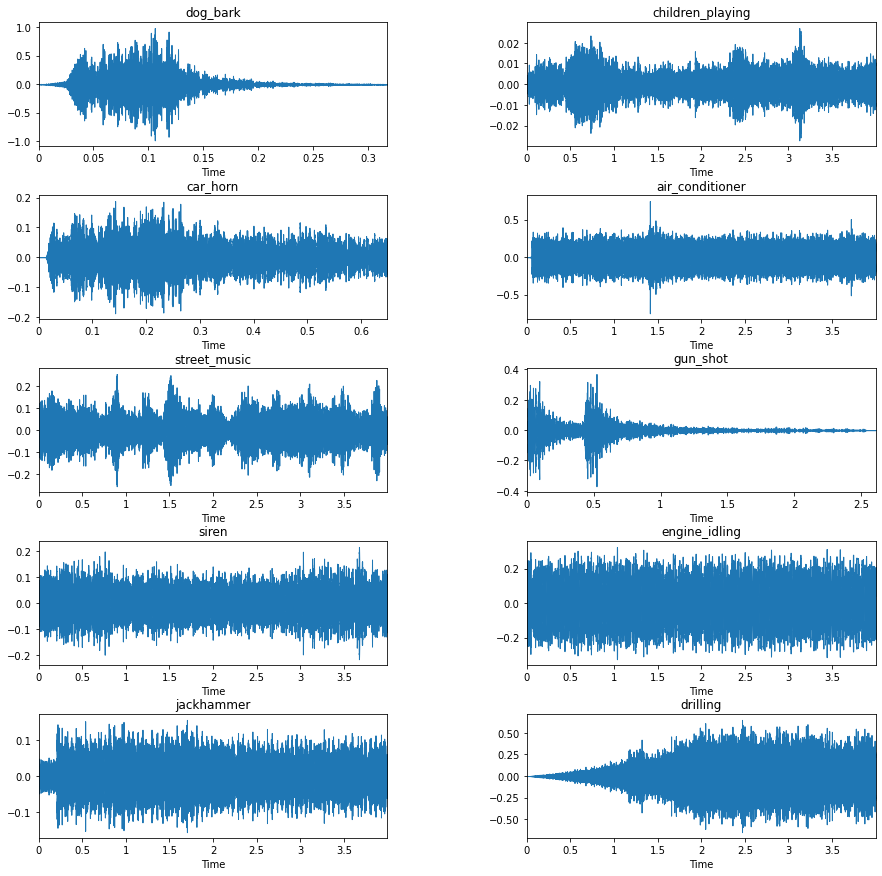

In [6]:
fig = plt.figure(figsize=(15,15))
# Log graphic of waveforms to Comet
#experiment.log_image('class_examples.png')
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels):
    fn = files[label]
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sample_rate = librosa.load(fn)
    librosa.display.waveplot(data, sr= sample_rate)
plt.savefig('class_examples.png')

In [7]:
fn = '/kaggle/input/urbansounds/UrbanSound8K/audio/fold1/191431-9-0-66.wav'
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)
print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

Original sample rate: 48000
Librosa sample rate: 22050


In [8]:
print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio),np.max(scipy_audio)))
print('Librosa audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio), np.max(librosa_audio)))

Original audio file min~max range: -1869 to 1665
Librosa audio file min~max range: -0.05 to -0.05


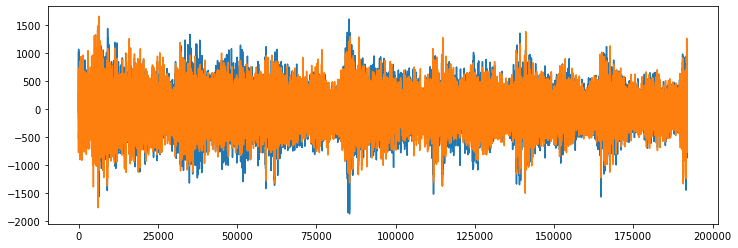

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)
plt.savefig('original_audio.png')

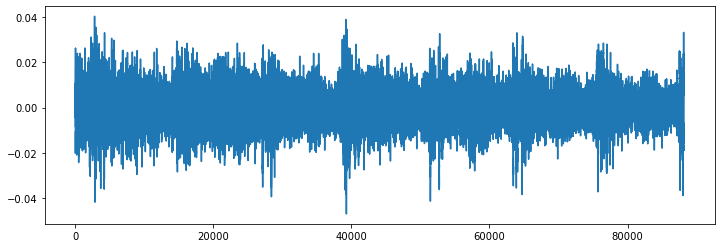

In [10]:
# Librosa: mono track
plt.figure(figsize=(12,4))
plt.plot(librosa_audio)
plt.savefig('librosa_audio.png')

In [11]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = n_mfcc)

In [12]:
print(mfccs.shape)

(40, 173)


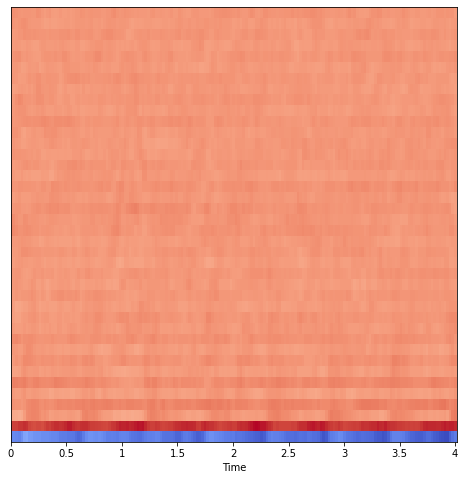

In [13]:
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')
plt.savefig('MFCCs.png')

In [14]:
print(keras.__version__)
print(tf.__version__)

2.4.3
2.4.0


In [15]:
#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

In [16]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16878719141084371744
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15685569792
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12649210602656098242
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [17]:
tf.debugging.set_log_device_placement(False)



In [18]:
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [19]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)


Num GPUs Available:  1


In [20]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    return mfccs_processed

In [21]:
features = []
#this may take some time to process
# Iterate through each sound file and extract the features 
fulldatasetpath = '/kaggle/input/urbansounds/UrbanSound8K/audio/'
for index, row in df.iterrows():
    slice_file_name = 'fold'+str(row["fold"])+'/'+str(row["slice_file_name"])
    file_name = os.path.join(os.path.abspath(fulldatasetpath), slice_file_name)
    #file_name = '/kaggle/input/urbansounds/UrbanSound8K/audio/fold{}/{}'.format(row['fold'],row['slive_file_name'])
    #  path = '/kaggle/input/urbansounds/UrbanSound8K/audio/fold{}/{}'.format(tmp['fold'][0], tmp['slice_file_name'][0])
    class_label = row["class"]
    data = extract_features(file_name)
    #appending the fold+#+file_name , for later reference into the specific files, and be able to acess them
    features.append([slice_file_name,data, class_label])
# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['file_name','feature','class_label'])

/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In [22]:
featuresdf.head()

file_name  \
0    fold5/100032-3-0-0.wav   
1  fold5/100263-2-0-117.wav   
2  fold5/100263-2-0-121.wav   
3  fold5/100263-2-0-126.wav   
4  fold5/100263-2-0-137.wav   

                                             feature       class_label  
0  [-215.79301, 71.66612, -131.81377, -52.09133, ...          dog_bark  
1  [-424.68677, 110.56227, -54.14824, 62.01074, -...  children_playing  
2  [-459.56467, 122.800354, -47.92471, 53.265694,...  children_playing  
3  [-414.55377, 102.89691, -36.66495, 54.18041, 0...  children_playing  
4  [-447.397, 115.0954, -53.809113, 61.60859, 1.6...  children_playing

In [23]:
print(featuresdf.class_label.unique())
len(featuresdf.class_label.unique())

['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']


10

In [24]:
featuresdf.iloc[0]['feature']

array([-2.1579301e+02,  7.1666122e+01, -1.3181377e+02, -5.2091331e+01,
       -2.2115967e+01, -2.1764179e+01, -1.1183748e+01,  1.8912680e+01,
        6.7266378e+00,  1.4556893e+01, -1.1782046e+01,  2.3010373e+00,
       -1.7251301e+01,  1.0052423e+01, -6.0094995e+00, -1.3153188e+00,
       -1.7693510e+01,  1.1171225e+00, -4.3699450e+00,  7.2629523e+00,
       -1.1815969e+01, -7.4952617e+00,  5.4577131e+00, -2.9442451e+00,
       -5.8693881e+00, -9.8654270e-02, -3.2121708e+00,  4.6092505e+00,
       -5.8293276e+00, -5.3475080e+00,  1.3341196e+00,  7.1307821e+00,
       -7.9450905e-02,  1.7109243e+00, -5.6942000e+00, -2.9041712e+00,
        3.0366950e+00, -1.6827593e+00, -8.8585806e-01,  3.5438892e-01],
      dtype=float32)

In [25]:
#Number of rows/soundfiles in the dataframe
len(featuresdf)

8732

In [26]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))
z = np.array(featuresdf.file_name.tolist())

In [27]:
# split the dataset 
from sklearn.model_selection import train_test_split 
#train is 0.8 of total
#stratify makes sure that we have an equal destribution of the differnt labels, ie. so all the dogs arent in one set
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(X, yy, z, test_size=0.2, random_state = 127  , shuffle=True,stratify=yy)
#validation size 10% of test corresponding to 0.1 of total
#test is 0.1 of total
x_test, x_val, y_test, y_val, z_test, z_val = train_test_split(x_test, y_test,z_test, test_size=0.5, random_state = 2)

In [28]:
num_labels = yy.shape[1]
def build_model_graph(input_shape=(n_mfcc,)):
    model = Sequential()
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')    
    return model
model = build_model_graph()

In [29]:
# Display model architecture summary 
#model.summary()
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               10496     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2

In [30]:
print("Pre-training accuracy: %.4f%%" % accuracy)

Pre-training accuracy: 9.6220%


In [31]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (3, 0.05),
    (6, 0.01),
    (9, 0.005),
    (12, 0.001),
    (100, 0.0001),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

In [32]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [33]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 
import tensorflow as tf

num_epochs = 1000
num_batch_size = 256 #256

#log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

my_callbacks = [
    #patience is how long the it will keep training after it has gotten a worse accuracy, if no better result has been found in the meantime
    EarlyStoppingAtMinLoss(patience=200),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    CustomLearningRateScheduler(lr_schedule)
  #  tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1),
]

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_val, y_val), verbose=1,callbacks=my_callbacks)



Epoch 1/1000

Epoch 00000: Learning rate is 0.0010.
28/28 [==============================] - 1s 19ms/step - loss: 20.8230 - accuracy: 0.1602 - val_loss: 1.9638 - val_accuracy: 0.3307
Epoch 2/1000

Epoch 00001: Learning rate is 0.0010.
28/28 [==============================] - 0s 4ms/step - loss: 4.7930 - accuracy: 0.2165 - val_loss: 2.1790 - val_accuracy: 0.1773
Epoch 3/1000

Epoch 00002: Learning rate is 0.0010.
28/28 [==============================] - 0s 4ms/step - loss: 2.6204 - accuracy: 0.2160 - val_loss: 2.2052 - val_accuracy: 0.2048
Epoch 4/1000

Epoch 00003: Learning rate is 0.0500.
28/28 [==============================] - 0s 5ms/step - loss: 2.1713 - accuracy: 0.2306 - val_loss: 2.0154 - val_accuracy: 0.2414
Epoch 5/1000

Epoch 00004: Learning rate is 0.0500.
28/28 [==============================] - 0s 4ms/step - loss: 2.1649 - accuracy: 0.2196 - val_loss: 2.0221 - val_accuracy: 0.2483
Epoch 6/1000

Epoch 00005: Learning rate is 0.0500.
28/28 [==============================] - 

In [34]:
from keras.models import load_model

time_now = datetime.now().strftime("%Y%m%d-%H%M%S")

model.save('my_model.h5'+time_now)  # creates a HDF5 file 'my_model.h5'


# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')


In [35]:
#del model  # deletes the existing model

In [36]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


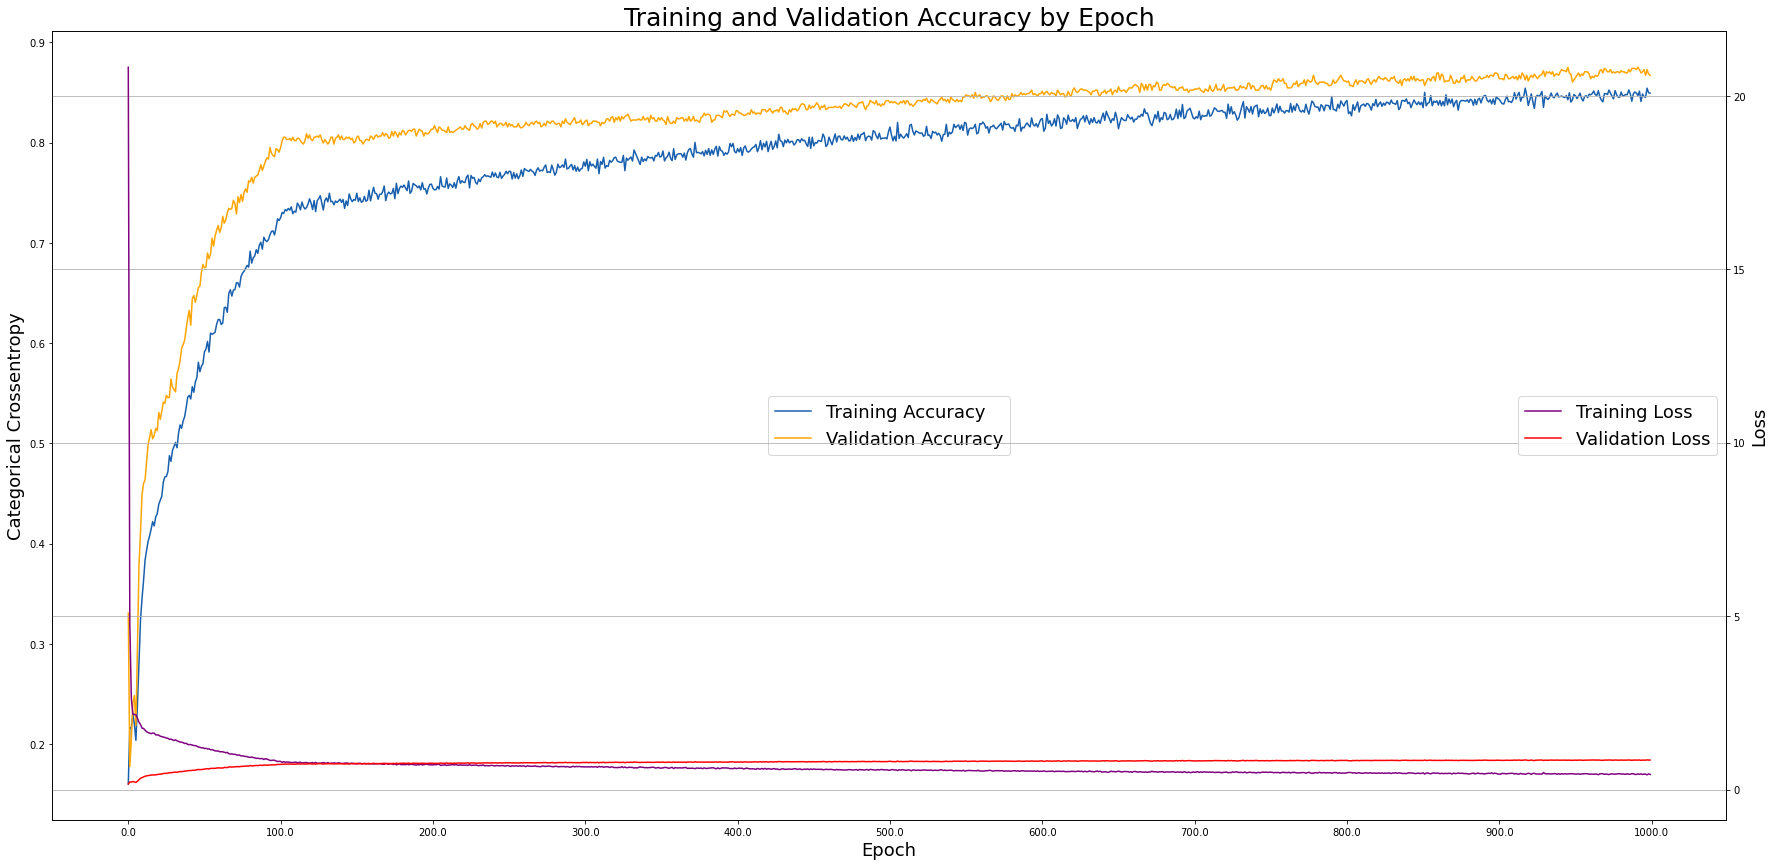

<Figure size 432x288 with 0 Axes>

In [37]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']



# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(30,15))


# Generate line plot of training, testing loss over epochs.
ax.set_xlabel('Epoch', fontsize = 18,rotation=0)
ax.set_ylabel('Categorical Crossentropy', fontsize = 18)
ax.plot(train_accuracy, label='Training Accuracy', color='#185fad')
ax.plot(val_accuracy, label='Validation Accuracy', color='orange')
ax.legend(fontsize = 18,loc=10)

# Set title

plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)

ticks=[]
for i in range(0,11):
    var = num_epochs/10
    ticks.append(var*i)


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(train_loss, label='Training Loss', color='purple')
ax2.plot(train_accuracy, label='Validation Loss', color='red')
ax2.set_ylabel('Loss',fontsize=18)


"""
'best' 	0
'upper right' 	1
'upper left' 	2
'lower left' 	3
'lower right' 	4
'right' 	5
'center left' 	6
'center right' 	7
'lower center' 	8
'upper center' 	9
'center' 	10
"""

ax2.legend(fontsize = 18,loc=5)
plt.xticks(ticks=ticks,labels=ticks,rotation=0)


# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.grid()
plt.show()
plt.savefig('training_loss_graph.png');



In [38]:
# Evaluating the model on the training and testing set
train_score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.3%}".format(train_score[1]))
test_score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.3%}".format(test_score[1]))

Training Accuracy: 94.345%
Testing Accuracy: 86.598%



# Now that we have evaluated the model, lets take a close look at the dataset and see which files it was unable to predict # 

In [39]:
# We get our predictions from the test data
preds = np.argmax(model.predict(x_test),axis=1)

In [40]:
print(preds)

[2 9 2 2 5 9 3 0 7 7 4 2 8 3 7 0 5 2 9 7 5 8 1 5 2 2 9 3 1 8 1 8 7 4 9 7 9
 0 7 2 8 7 7 2 8 4 5 9 0 7 8 7 7 4 0 7 9 1 0 5 0 5 4 0 7 7 6 5 7 3 8 0 4 0
 5 7 8 8 4 1 4 8 3 2 1 6 5 3 3 4 0 2 4 7 7 2 4 7 2 5 7 7 3 5 0 7 7 0 3 3 2
 8 7 5 9 2 4 3 6 4 3 8 4 6 3 9 3 2 1 9 5 0 9 2 0 7 3 3 7 4 0 5 0 2 1 4 5 2
 1 2 8 0 9 5 9 9 5 9 1 1 1 8 3 9 7 4 9 7 3 7 2 0 4 5 5 9 9 9 1 0 8 9 3 2 8
 9 2 2 2 2 9 2 2 5 3 1 1 1 4 4 2 2 9 2 5 6 9 0 3 2 8 8 6 5 2 5 7 4 8 2 6 3
 4 8 8 6 7 2 8 2 9 7 3 0 3 7 2 7 5 4 1 2 8 2 4 7 2 1 5 8 8 2 5 0 2 1 2 3 9
 1 5 8 7 3 9 0 7 4 0 7 8 5 3 8 0 5 2 0 7 5 7 7 1 2 2 2 4 8 0 7 3 8 9 1 6 0
 0 2 5 8 2 3 0 5 5 0 2 0 8 3 7 2 4 3 8 9 9 3 3 2 9 8 5 6 9 9 2 2 7 0 2 9 9
 4 5 7 5 0 1 5 7 4 8 8 9 9 1 5 7 2 0 2 2 2 0 0 9 3 1 8 9 5 9 3 0 3 3 6 0 7
 4 4 3 4 4 3 1 4 4 8 9 1 7 4 1 7 4 9 7 4 9 0 9 9 9 9 5 4 3 8 6 2 2 0 5 4 0
 3 2 2 8 4 0 9 2 4 8 4 9 4 9 9 3 2 6 9 3 0 0 7 4 9 9 2 8 2 3 5 0 7 3 4 5 3
 4 0 0 9 2 7 3 6 5 0 8 3 9 6 4 4 7 2 9 5 3 9 7 2 3 9 2 2 8 9 8 5 6 4 7 4 2
 0 9 2 8 5 9 8 9 7 5 0 7 

In [41]:
# We transform back our predictions to the strings of what they represent
invpreds = le.inverse_transform(preds)
print(invpreds)

['children_playing' 'street_music' 'children_playing' 'children_playing'
 'engine_idling' 'street_music' 'dog_bark' 'air_conditioner' 'jackhammer'
 'jackhammer' 'drilling' 'children_playing' 'siren' 'dog_bark'
 'jackhammer' 'air_conditioner' 'engine_idling' 'children_playing'
 'street_music' 'jackhammer' 'engine_idling' 'siren' 'car_horn'
 'engine_idling' 'children_playing' 'children_playing' 'street_music'
 'dog_bark' 'car_horn' 'siren' 'car_horn' 'siren' 'jackhammer' 'drilling'
 'street_music' 'jackhammer' 'street_music' 'air_conditioner' 'jackhammer'
 'children_playing' 'siren' 'jackhammer' 'jackhammer' 'children_playing'
 'siren' 'drilling' 'engine_idling' 'street_music' 'air_conditioner'
 'jackhammer' 'siren' 'jackhammer' 'jackhammer' 'drilling'
 'air_conditioner' 'jackhammer' 'street_music' 'car_horn'
 'air_conditioner' 'engine_idling' 'air_conditioner' 'engine_idling'
 'drilling' 'air_conditioner' 'jackhammer' 'jackhammer' 'gun_shot'
 'engine_idling' 'jackhammer' 'dog_bark' 'sir

In [42]:
#See how the data of ytest looks like
print(y_test)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [43]:
#Converting the class labels into a single value, from the 1/0 on the index that they would otherwise represent
darray_y_test = np.argmax(y_test,axis=1) 
#print(darray_y_test)

In [44]:
#Converting back to the strings with the use of the encoder
invy_test = le.inverse_transform(darray_y_test)

In [45]:
#Print how they look on string form
#print(invy_test)

In [46]:
# Create new data frame with the features
dfx = pd.DataFrame(x_test)
# Create data frame with the class test labels
dfy = pd.DataFrame(invy_test)
#create data frame with the filenames
dfz = pd.DataFrame(z_test)
#Addeing the real values of the test class labels
dfx['class_labels'] = dfy
#Adding the predictions of the class labels
dfx['preds'] = invpreds
#adding filenames to the df
dfx['file_name'] = dfz

In [47]:
#Print the whole dataframe with all the features and the test values predicted and the real ones
dfx.head()

0           1          2          3          4          5  \
0 -402.602966   81.711128 -46.520691  42.082417  -1.227985  32.927849   
1 -274.038849  125.486359 -21.153229  44.853249 -12.147538  30.652849   
2 -384.161774  191.123306 -25.551105  20.614342  -8.866016  17.107279   
3 -355.596924  105.955048 -48.766628  57.914875  -4.303929  19.364935   
4  -92.159874  129.114334 -34.144253  32.560410 -19.393984   4.110746   

          6          7          8          9  ...        33        34  \
0 -2.544231  -4.374114   2.837502   4.750813  ... -0.917909 -0.924903   
1 -5.249992  17.496164  -7.764944  10.642563  ...  0.945057 -2.228498   
2 -6.459805   6.444135  -2.758299  12.891774  ... -2.237253  0.056987   
3  2.594625  10.438691   4.662246  10.513984  ... -0.979985 -1.907905   
4 -3.522416   3.996360 -11.052378  14.119355  ...  3.715068  0.664820   

         35        36        37        38        39      class_labels  \
0  3.039554 -0.222245  0.762522  0.911863 -4.655969  children_playing   
1 -0.127383 -1.927432  2.249818  0.324153 -0.885308  children_playing   
2 -3.123534 -0.615348 -1.430095 -2.211671 -1.708939  children_playing   
3  2.495256  0.844629  0.017631 -1.676227  0.225263  children_playing   
4  4.070432 -0.658598  2.598671  0.749381  3.665938     engine_idling   

              preds                file_name  
0  children_playing    fold9/60935-2-0-4.wav  
1      street_music    fold2/84359-2-0-8.wav  
2  children_playing  fold3/132855-2-0-70.wav  
3  children_playing   fold9/99500-2-0-23.wav  
4     engine_idling  fold6/111386-5-1-11.wav  

[5 rows x 43 columns]

In [48]:
# Checking which predictions I got wrong, printing the rows of the unequal predictions
dfx[dfx['class_labels'] != dfx['preds']]

0           1           2          3          4          5  \
1   -274.038849  125.486359  -21.153229  44.853249 -12.147538  30.652849   
6   -340.996613  121.530830   19.897600  41.787441 -49.006210  14.148498   
7   -145.487869  134.853577    0.239085  12.903329 -14.109360  16.716108   
17   -87.524086   45.369045 -133.626205  11.826305 -13.909385  18.291676   
43  -297.332336  141.645508  -34.123833  35.317810 -15.456478  21.002205   
..          ...         ...         ...        ...        ...        ...   
841 -174.016113  131.570694    1.463891  22.149065 -24.977976  -6.330420   
849 -119.805885   83.553101  -35.171436  11.503080 -40.184181   3.356997   
856 -194.460587   66.466377  -20.599743  40.668610  -2.745445  27.694735   
858 -430.039886  122.251389  -10.725566   1.936205 -17.908552  19.150290   
866 -245.348404   87.671829  -27.466589  25.622929 -17.131029  18.533701   

             6          7          8          9  ...        33        34  \
1    -5.249992  17.496164  -7.764944  10.642563  ...  0.945057 -2.228498   
6   -21.692453   8.828691 -18.987843   8.107555  ... -2.741698  0.058255   
7   -15.488802  15.423511 -15.447452   5.378959  ...  2.720072  1.960865   
17  -12.744842  22.713739 -10.810475  13.825772  ... -0.272772  1.758869   
43  -22.527378  20.511896 -14.715371   6.267078  ... -1.594739 -2.127392   
..         ...        ...        ...        ...  ...       ...       ...   
841 -36.259464 -24.791355 -22.346113   4.207899  ... -0.747111 -1.834711   
849 -21.250116   3.731039 -29.304735  -3.588161  ...  1.066721 -3.773838   
856  -0.895742  18.116657   0.956337   7.160682  ...  2.017418  0.179782   
858 -16.412643   6.350818 -13.739179   6.328163  ... -0.817927 -1.877246   
866  -3.896896   6.913278 -13.974294  -6.903242  ... -1.043900  4.587646   

           35        36        37        38        39      class_labels  \
1   -0.127383 -1.927432  2.249818  0.324153 -0.885308  children_playing   
6   -3.524642 -2.164908 -4.015433 -3.849640 -2.339185          gun_shot   
7    2.709929  0.233017  1.033667  0.088187  2.828801             siren   
17  -0.137367  1.914149  0.772713  1.045334  3.805379          drilling   
43  -0.449963 -2.870357 -1.985130  0.012652 -0.046230      street_music   
..        ...       ...       ...       ...       ...               ...   
841 -2.854176 -3.105643  2.075577  0.337853 -1.184353          dog_bark   
849 -0.330563 -3.666144  0.557476 -2.421848  0.113699          drilling   
856  0.631087 -0.757686 -0.480530  0.851845  1.589795          gun_shot   
858 -1.133178 -2.901712 -1.420905 -1.421698  0.268585          dog_bark   
866 -0.071356  2.603520 -0.045992  1.333950  1.602562          gun_shot   

                preds                file_name  
1        street_music    fold2/84359-2-0-8.wav  
6            dog_bark    fold4/24632-6-0-0.wav  
7     air_conditioner   fold3/94636-8-0-20.wav  
17   children_playing   fold3/103199-4-4-0.wav  
43   children_playing  fold4/194458-9-1-75.wav  
..                ...                      ...  
841      street_music      fold4/344-3-0-0.wav  
849  children_playing      fold7/518-4-0-3.wav  
856  children_playing    fold5/77247-6-0-0.wav  
858  children_playing   fold2/69883-3-0-20.wav  
866  children_playing    fold3/34708-6-3-0.wav  

[117 rows x 43 columns]

In [49]:
#Extracting the pairs that are not equal
df_unequal = dfx[dfx['class_labels'] != dfx['preds']]


pd.crosstab(df_unequal.preds, df_unequal.class_labels)

class_labels      air_conditioner  car_horn  children_playing  dog_bark  \
preds                                                                     
air_conditioner                 0         0                 3         1   
car_horn                        0         0                 1         0   
children_playing                4         1                 0        13   
dog_bark                        0         0                 3         0   
drilling                        0         0                 1         1   
engine_idling                   0         0                 1         2   
gun_shot                        0         0                 0         2   
jackhammer                      0         0                 1         0   
siren                           0         0                 0         1   
street_music                    1         5                10         8   

class_labels      drilling  engine_idling  gun_shot  jackhammer  siren  \
preds                                                                    
air_conditioner          0              0         0           0      1   
car_horn                 0              0         0           0      0   
children_playing         2              0         7           0      5   
dog_bark                 1              1         4           0      3   
drilling                 0              0         0           2      1   
engine_idling            0              0         0           0      0   
gun_shot                 0              0         0           0      0   
jackhammer               1              0         1           0      0   
siren                    0              0         1           0      0   
street_music             2              0         2           2      2   

class_labels      street_music  
preds                           
air_conditioner              3  
car_horn                     1  
children_playing            15  
dog_bark                     0  
drilling                     1  
engine_idling                0  
gun_shot                     0  
jackhammer                   0  
siren                        0  
street_music                 0

*High correlation between the results of children_playing and dog_barking, aswell as gun_shot*

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [50]:
#Play a sound from the dataset
from IPython.display import Audio
import IPython.display as ipd
from IPython.display import clear_output
import sys
sound_file = '/kaggle/input/urbansounds/UrbanSound8K/audio/'
for index, row in df_unequal.iterrows():
    slice_name = row['file_name']
    
    name= sound_file+slice_name
    
    print("Name of file: {} , Predicted to be: {} , Real Value: {} ".format(slice_name , row['preds'] ,row['class_labels']))
    
    
    input(ipd.display(ipd.Audio(name,autoplay=True)))
    #ipd.set_matplotlib_close(close=True)
    #sys.stdout.flush()
    clear_output(wait=True)
    


Name of file: fold2/84359-2-0-8.wav , Predicted to be: street_music , Real Value: children_playing 


StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

One instance in particular classified to be car_horn, and predicted to be a jackhammer. But the car_horn is in the background, and the jackhammer is in the foreground. So I think the classifier actually does a better job here than the human person who classified the sound bite. fold4/7389-1-0-4.wav. 
* Some Sound bites are so low amplitude that is not possible to distinguish what the sound actually is

In [51]:
#This file is in folder 4. Jackhammer, car_horn example
Audio('/kaggle/input/urbansounds/UrbanSound8K/audio/fold4/7389-1-0-4.wav')

In [52]:
 #This file is in folder 4. Does not sound like street_music nor children playing, 
    #but it does sound like streenoise although this is not a label
    #It probably says children_playing because there are people talking
Audio('/kaggle/input/urbansounds/UrbanSound8K/audio/fold4/194458-9-1-75.wav')
    

In [53]:
#creating a dataframe for comparison between the pairs that are not equal for comparison 
#This is to test whether they have some similar features and in this case which
df_numerical = pd.DataFrame(x_test)
df_preds = pd.DataFrame(preds)
df_numerical['preds'] = df_preds
df_classlabels = pd.DataFrame(darray_y_test)
df_numerical['class_labels'] = df_classlabels

#Extracting the pairs that are not equal
df_numerical = df_numerical[df_numerical['class_labels'] != df_numerical['preds']]


pd.crosstab(df_numerical.preds, df_numerical.class_labels)

class_labels  0  1   2   3  4  5  6  7  8   9
preds                                        
0             0  0   3   1  0  0  0  0  1   3
1             0  0   1   0  0  0  0  0  0   1
2             4  1   0  13  2  0  7  0  5  15
3             0  0   3   0  1  1  4  0  3   0
4             0  0   1   1  0  0  0  2  1   1
5             0  0   1   2  0  0  0  0  0   0
6             0  0   0   2  0  0  0  0  0   0
7             0  0   1   0  1  0  1  0  0   0
8             0  0   0   1  0  0  1  0  0   0
9             1  5  10   8  2  0  2  2  2   0